In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matrixprofile as mp
%matplotlib inline
import pywt
from numpy import array

In [14]:
def split_sequence(sequence, n_steps_in, n_steps_out, step_interval, n_step_lookahead):
    X, y = list(), list()
    example_count = int((len(sequence)/step_interval))
    for i in range(example_count):
        # find the end of this pattern
        end_ix = (i*step_interval) + n_steps_in
        out_start_ix = end_ix + n_step_lookahead -1
        out_end_ix = end_ix + n_steps_out + n_step_lookahead -1
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[(i*step_interval):end_ix], sequence[out_start_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [20]:
def generate_training_val_examples_univariate_output(data):
 
    #Filter inputs, standardize
    data =data[inputs]
    

    #Creat input:output examples
    data = data[start_date:end_date].to_numpy()
    X, y = split_sequence(data, n_steps_in, n_steps_out, step_interval, n_step_lookahead)
    
    X_train, X_val = np.split(X, [int(0.7 * len(X))])
    
    y_train, y_val = np.split(y, [int(0.7 * len(X))])

    
    #Reshape to 3D for LSTM, filter output to only the first input
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(inputs)))
    y_train =y_train.reshape((y_train.shape[0], y_train.shape[1], len(inputs)))[:,:,:1]
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], len(inputs)))
    y_val = y_val.reshape((y_val.shape[0], y_val.shape[1], len(inputs)))[:,:,:1]

    
    return X_train, y_train, X_val, y_val


In [138]:
def get_x_val_dates(): 
    series =data[:end_date].index.values.astype(np.int64) // 10 ** 9
    x,y = split_sequence(series,n_steps_in, n_steps_out, step_interval, n_step_lookahead)
    x_train, x_val_timestamps = np.split(x, [int(0.7 * len(x))])
    Y_train, Y_val_timestamps = np.split(y, [int(0.7 * len(y))])
    return x_val_timestamps

In [164]:
get_x_val_dates()[1,288:][0::288].shape

(14,)

In [145]:
def generate_ticks_lables_xval(X_train, X_val, y_train, y_val, tick_interval, n_step_lookahead, training_example):
    ticks=np.arange(0,X_val.shape[1],tick_interval)
    DATE_TIME_STRING_FORMAT='%m-%d %H:%M'
    x_val_ts = get_x_val_dates()
    label_ts = x_val_ts[training_example][0::tick_interval]
    labels=[]
    for i in label_ts:
        labels.append(datetime.fromtimestamp(i).strftime('%m-%d %H:%M'))
    
    
     
    labels=labels[:len(ticks)]
    return ticks, labels

In [137]:
np.arange(0,len(X_val),288)

array([   0,  288,  576,  864, 1152])

In [7]:
percentile_data = pd.read_csv (r'C:\Users/conal/Desktop/MCM/Practicum - Copy/data/block gas price percentile data.csv', header=0)
percentile_data['datetime'] = pd.to_datetime(percentile_data['block_timestamp'], format = '%Y-%m-%d %H:%M:%S UTC')

percentile_data = percentile_data.sort_values(by='datetime',ascending=False)
percentile_data = percentile_data.set_index('datetime')
percentile_data = percentile_data.resample('5T').mean()
percentile_data = percentile_data/1000000000

In [8]:
usage_data = pd.read_csv (r'C:\Users\conal\Desktop\MCM\Practicum - Copy\data\ETH,gas,usage merged 11-26 to 05-26.csv', header=0)
usage_data['datetime'] = pd.to_datetime(usage_data['datetime'], format = '%Y-%m-%d %H:%M:%S')
usage_data = usage_data.set_index('datetime')

usage_data = usage_data.squeeze()
usage_data = usage_data.astype('float')
usage_data = usage_data.resample('5T').mean()

In [9]:
usage_data2 = pd.read_csv (r'C:\Users\conal\Desktop\MCM\Practicum - Copy\data\Contract counts 2021-11-26 to 2022-05-26.csv', header=0, index_col=0)
usage_data2['datetime'] = pd.to_datetime(usage_data2['block_timestamp'], format = '%Y-%m-%d %H:%M:%S') 
usage_data2 = usage_data2.set_index('datetime')
usage_data2 = usage_data2.drop(['block_timestamp'], axis=1)
usage_data2 = usage_data2.squeeze()
usage_data2 = usage_data2.astype('float')
usage_data2 = usage_data2.resample('5T').sum()

In [11]:
data.columns

Index(['gas_used', 'base_fee_per_gas', 'transaction_count', 'size', 'Open',
       'avg_gas_price', 'max_gas_price', 'min_gas_price',
       'block_gas_0th_percentile', 'block_gas_5th_percentile',
       'block_gas_10th_percentile', 'block_gas_20th_percentile',
       'block_gas_30th_percentile', 'block_gas_40th_percentile',
       'block_gas_50th_percentile', 'block_gas_60th_percentile',
       'block_gas_70th_percentile', 'block_gas_80th_percentile',
       'block_gas_90th_percentile', 'block_gas_95th_percentile',
       'block_gas_100th_percentile', 'is_erc20', 'is_erc721', 'contracts'],
      dtype='object')

Downsample to 3min intervals, convert price to gwei

In [10]:
data = usage_data.merge(percentile_data, left_index=True, right_index=True)
data = data.merge(usage_data2, left_index=True, right_index=True)

D:\Anaconda\lib\site-packages\matrixprofile\visualize.py:375: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


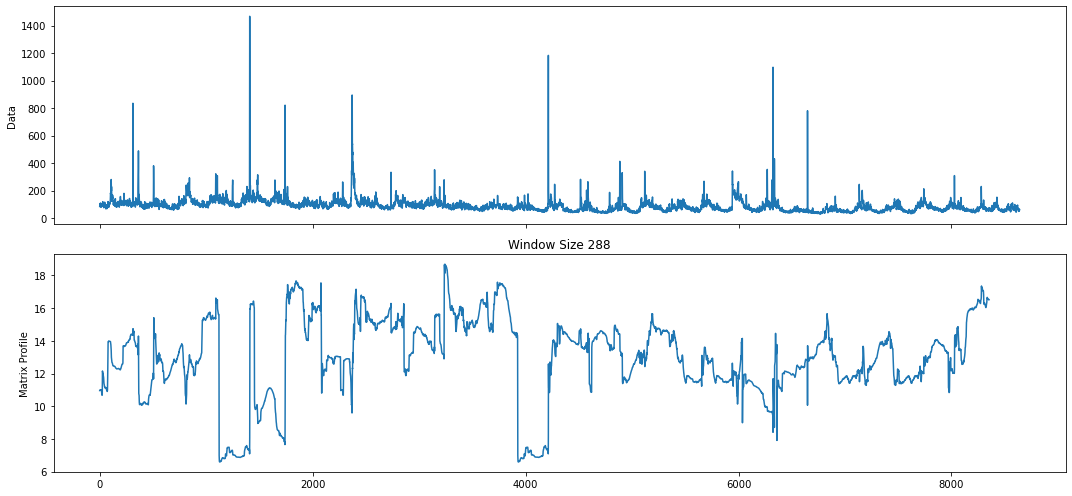

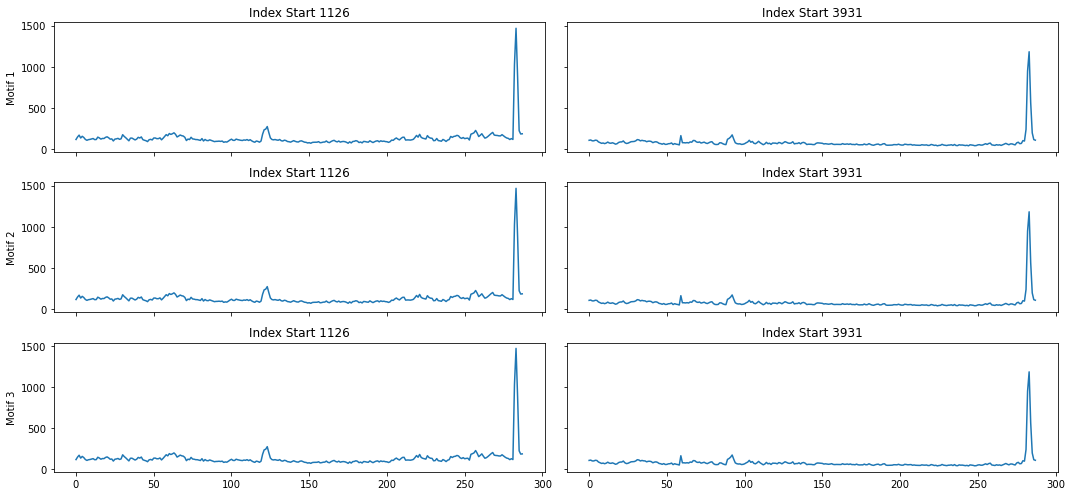

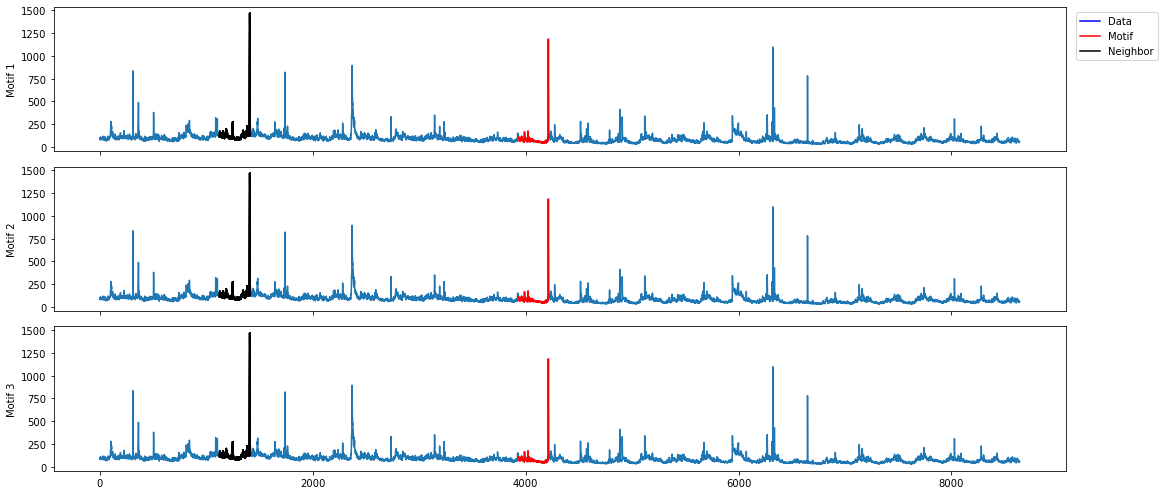

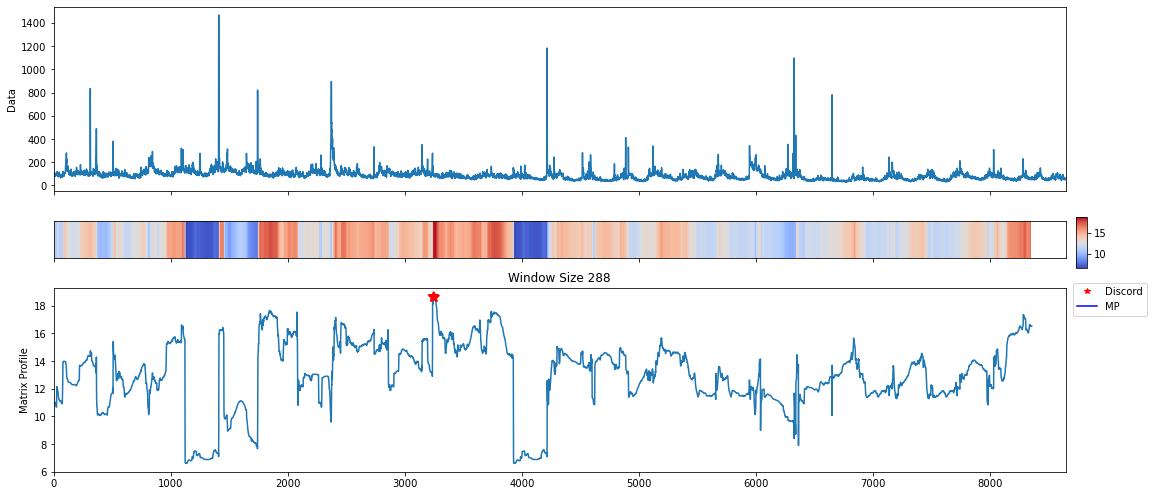

In [190]:
mp_profile, mp_figures = mp.analyze(data.loc[:'2021-12-26 00:00:00']['min_gas_price'].to_numpy(), windows=288)

## Lets look at the matrix profile for some training examples; 2 weeks of data

In [21]:
#Create Training Examples for all lookaheads
resample_rate = '5T'
end_dates = ['2021-12-26 23:55:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00', '2022-04-26 23:55:00'  ]
Start_dates = ['2021-11-26 00:00:00', '2021-12-26 00:00:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00']

#end_dates = ['2022-01-26 23:55:00', '2022-03-26 23:55:00']
#Start_dates = ['2021-11-26 00:00:00', '2022-01-26 00:00:00']
inputs = ['min_gas_price', 'block_gas_5th_percentile', 'block_gas_95th_percentile', 'gas_used', 'base_fee_per_gas', 'transaction_count', 'size', 'Open', 'contracts']
#No of timesteps behind to forecast on, no of timesteps to forecast ahead
n_steps_in = 4032+288
n_steps_out = 10
#How many timesteps between start of training examples
step_interval = 1
n_step_lookahead = 1
mp_window=288

In [25]:
for month in [0]:
    n_steps_in = 4032+288
    n_step_lookahead = 1
    start_date=Start_dates[month]
    end_date=end_dates[month]
    X_train, y_train, X_val, y_val = generate_training_val_examples_univariate_output(data)

In [211]:
mp_profile = mp.compute(X_val[-1,:,0], windows=288)

In [165]:
ticks, labels = generate_ticks_lables_xval(X_train, X_val[:,288:,], y_train, y_val, 288, n_step_lookahead,-1)

In [166]:
len(ticks)

14

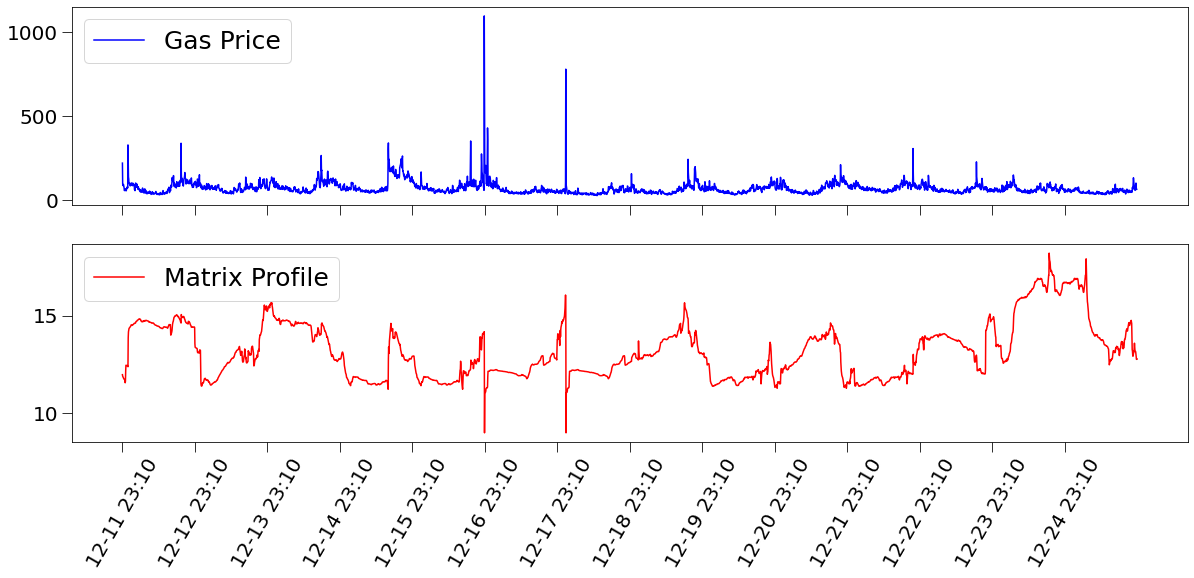

In [212]:

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.set_figwidth(20)
f.set_figheight(8)

ax1.plot(X_val[-1,288:,0], color='blue',label='Gas Price')
ax2.plot(mp_profile['mp'], color='red',label='Matrix Profile')

ax1.legend(loc='upper left',prop={'size': 25})
ax2.legend(loc='upper left',prop={'size': 25})
plt.setp(ax1, xticks=ticks, xticklabels=labels)
ax2.tick_params(axis='x', labelrotation=60,size=10, labelsize=20)
ax2.tick_params(axis='y', labelsize=20,size=10)
ax1.tick_params(axis='x', labelrotation=60,size=10, labelsize=20)
ax1.tick_params(axis='y', labelsize=20,size=10)

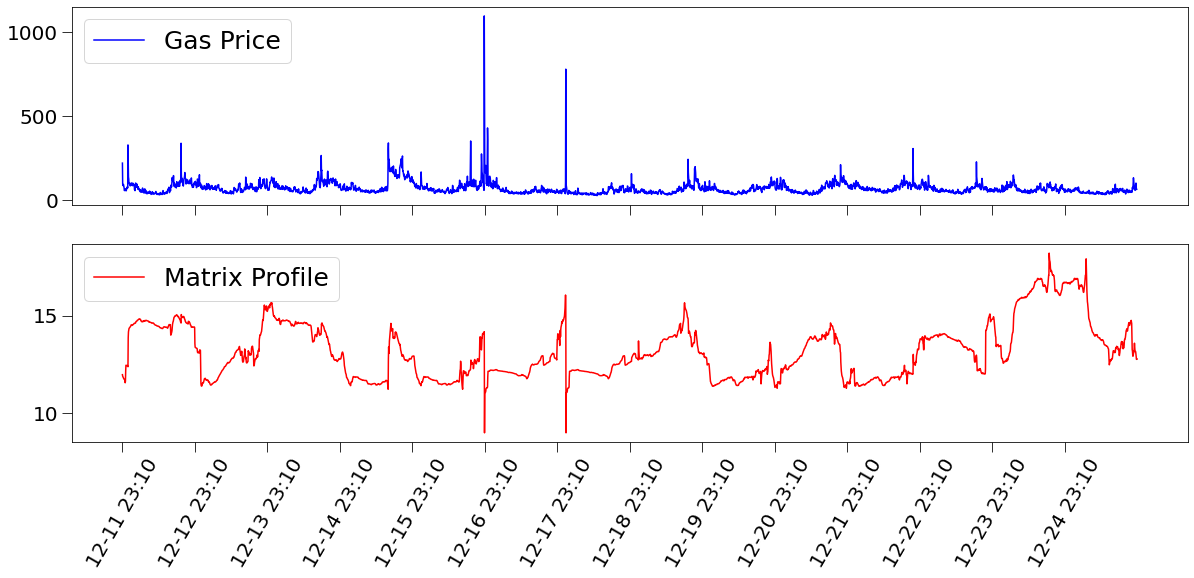

In [175]:

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.set_figwidth(20)
f.set_figheight(8)

ax1.plot(X_val[-1,288:,0], color='blue',label='Gas Price')
ax2.plot(mp_profile['mp'], color='red',label='Matrix Profile')

ax1.legend(loc='upper left',prop={'size': 25})
ax2.legend(loc='upper left',prop={'size': 25})
plt.setp(ax1, xticks=ticks, xticklabels=labels)
ax2.tick_params(axis='x', labelrotation=60,size=10, labelsize=20)
ax2.tick_params(axis='y', labelsize=20,size=10)
ax1.tick_params(axis='x', labelrotation=60,size=10, labelsize=20)
ax1.tick_params(axis='y', labelsize=20,size=10)



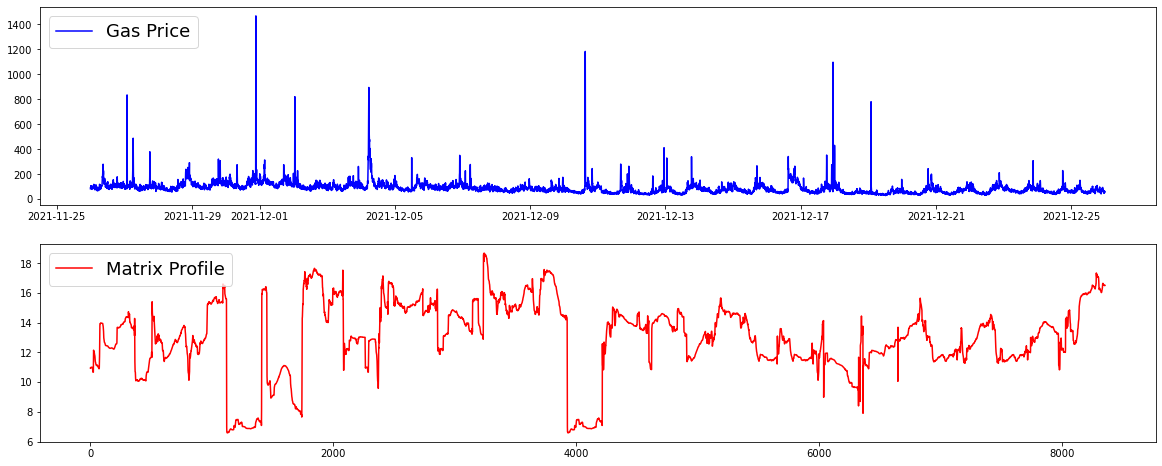

In [209]:
mp_profile = mp.compute(data.loc[:'2021-12-26 00:00:00']["min_gas_price"].to_numpy(), windows=288)

f, (ax1,ax2) = plt.subplots(2, 1)
f.set_figwidth(20)
f.set_figheight(8)

ax1.plot(data.loc[:'2021-12-26 00:00:00']["min_gas_price"], color='blue',label='Gas Price')
ax2.plot(mp_profile['mp'], color='red',label='Matrix Profile')

ax1.legend(loc='upper left',prop={'size': 18})
ax2.legend(loc='upper left',prop={'size': 18})






In [198]:
data.loc[:'2021-12-26 00:00:00']["min_gas_price"].to_numpy

<bound method IndexOpsMixin.to_numpy of datetime
2021-11-26 00:00:00     83.929691
2021-11-26 00:05:00     96.115518
2021-11-26 00:10:00     93.354997
2021-11-26 00:15:00     90.455134
2021-11-26 00:20:00    102.881786
                          ...    
2021-12-25 23:40:00     54.299054
2021-12-25 23:45:00     56.025732
2021-12-25 23:50:00     54.212498
2021-12-25 23:55:00     57.945402
2021-12-26 00:00:00     61.196612
Freq: 5T, Name: min_gas_price, Length: 8641, dtype: float64>

D:\Anaconda\lib\site-packages\matrixprofile\visualize.py:375: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


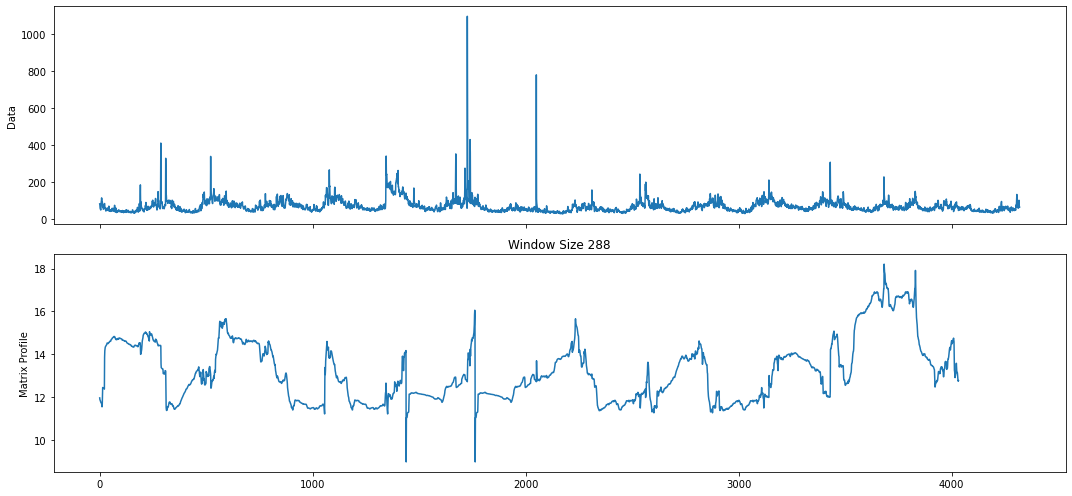

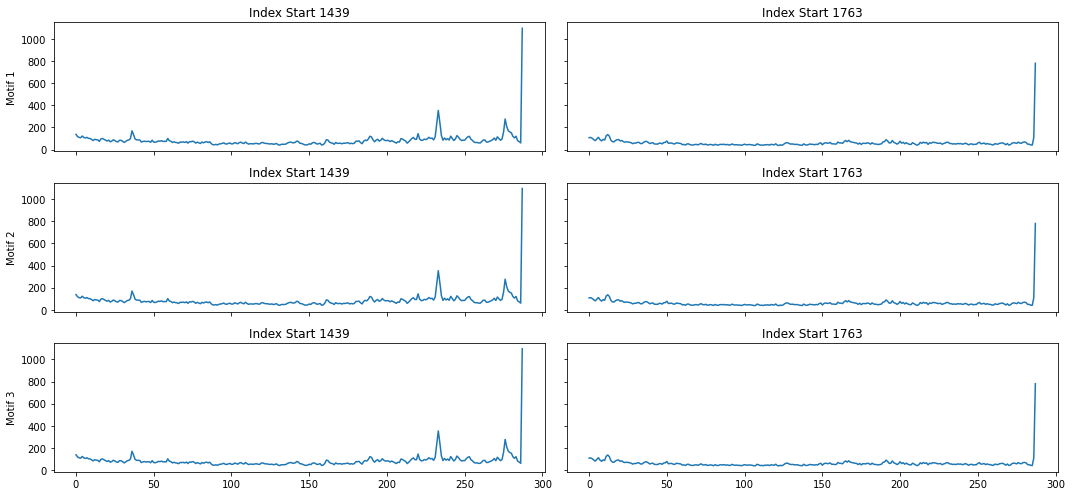

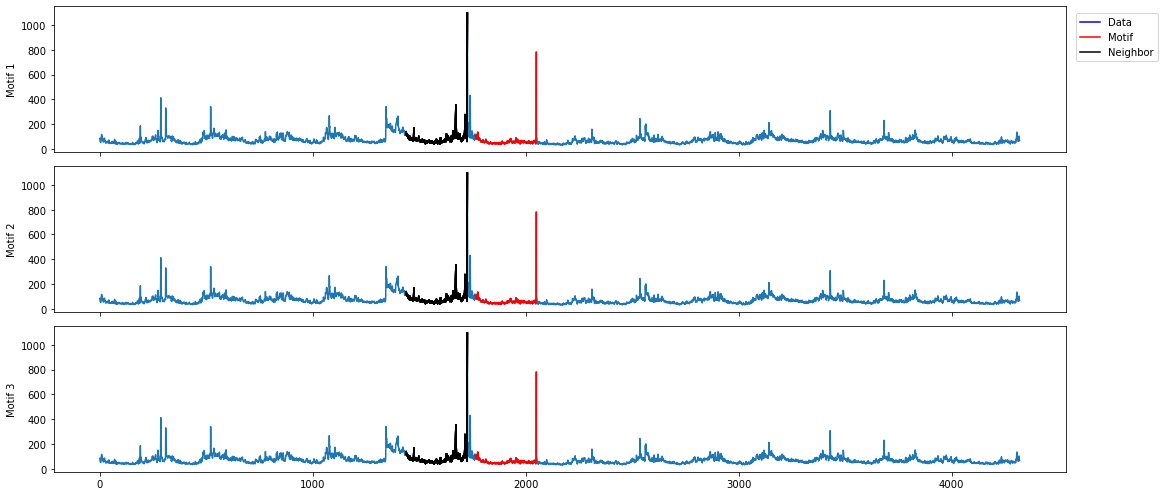

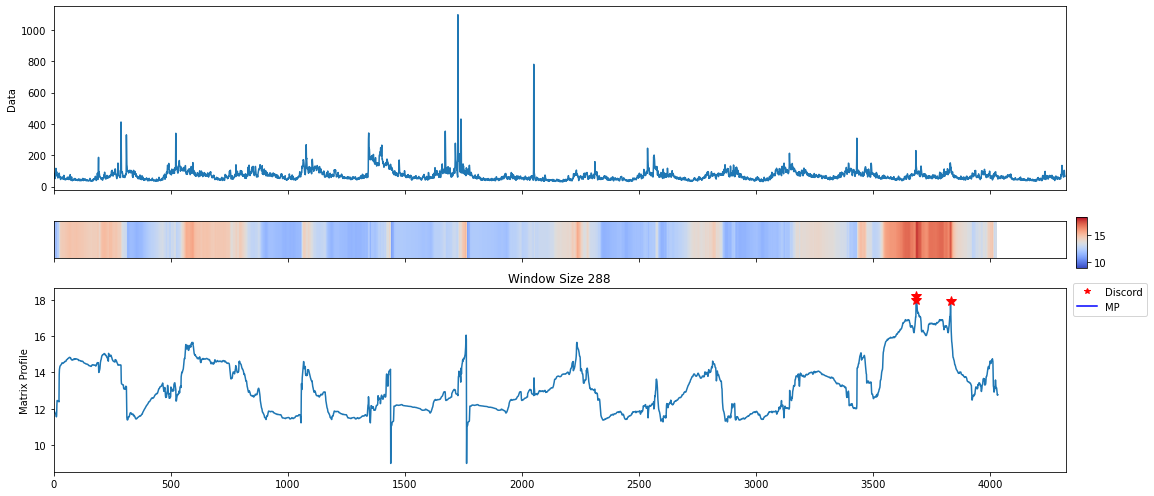

In [65]:
profile, figs = mp.analyze(X_val[-1,:,0], windows=288)

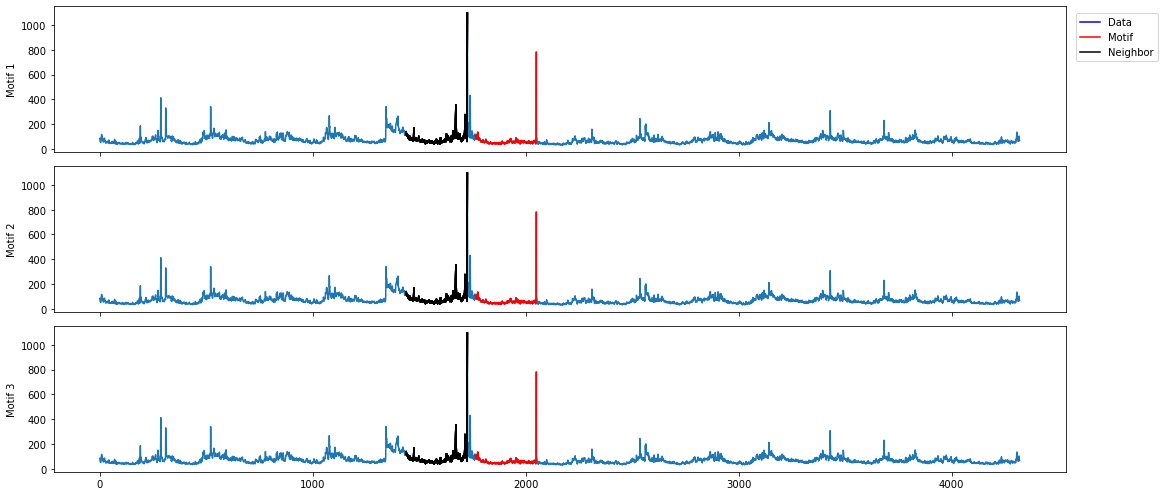

In [220]:
figs[2]
